# <center> Applications of No-Collision Transportation Maps in Manifold Learning  <center>
This notebook provides the main code to implement the no-collison map techinque from the paper "E. Negrini, L. Nurbekyan, Applications of No-Collision Transportation Maps in Manifold Learning ." 
The paper can be found here: 

For the comparison with Wassmap and LOT we use the original code provided in the corresponding papers:

# <center> Rotation Examples, Section 7.3 <center>

In [13]:
############## Import statements ########################

import sklearn
import numpy as np
import ot
import ot.plot

# networkx is a graph library 
import networkx as nx

import time

from sklearn import manifold as man
from sklearn.decomposition import PCA
from pydiffmap import diffusion_map as dm

import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.sparse
from pydiffmap import diffusion_map as dm


# NOTE: RBFInterpolator needs scipy>=1.7.0
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator
#from scipy.interpolate import RBFInterpolator

import math



from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator

from mpl_toolkits.axes_grid1 import ImageGrid

#LOT functions
from Functions.LOT_ML import *
from Functions.Gaussians import *



#No-collision functions
from Functions.no_collision import *

#Wassmap functions
from Functions.WassmapFunctions import *

#Data generator
from Functions.DataGenerator import *


In [2]:
########## global figure settings ####################

%matplotlib inline
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
        'axes.titlesize': 20
         }

plt.rcParams.update(params)
 
font = {'family':'serif','weight':'normal','size':18}
plt.rc('font',**font)


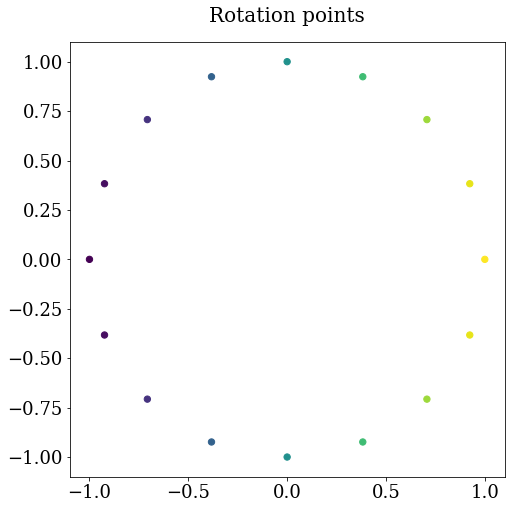

In [3]:
############# Rotation Grid Genaration #########################

# Picking parameter a = 2 will give results as in section 7.3.1
# Picking parameter a = 5 will give results as in section 7.3.2

num_samplepoints = 32
cx = 0
cy = 1
a = 2
b = 2
ellipse = generate_ellipse([cx,cy], a,b, samples = num_samplepoints)

# Generate translation set
num_rotations = 16
theta = np.linspace(0,2*np.pi,num=num_rotations,endpoint=False)
x = np.cos(theta)
y = np.sin(theta)
rotates = np.zeros((num_rotations,2))
for i in range(len(x)):
    rotates[i,0] = x[i]
    rotates[i,1] = y[i]
    

# Plot the rotation set 
fig1,ax1 = plt.subplots()
ax1.scatter(rotates[:,0],rotates[:,1],s=40,c=rotates[:,0])
ax1.set_aspect('equal')
ax1.set_title('Rotation points', pad=20)
plt.show()


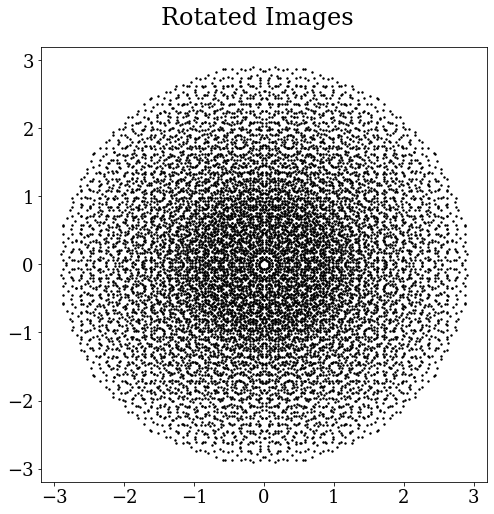

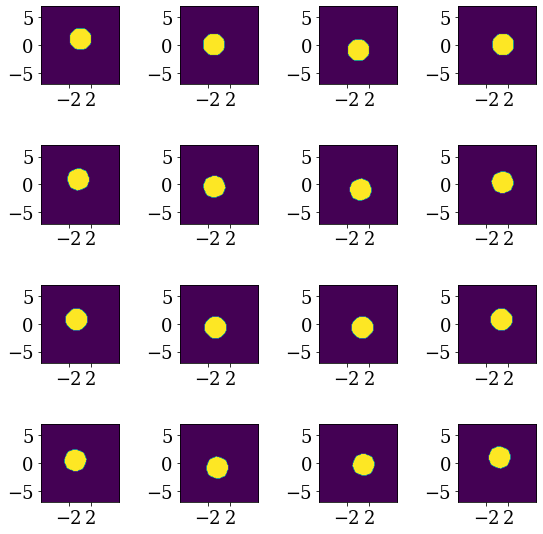

In [4]:
################### Generate translation images and image tensor ###########################
rot_images = np.zeros((ellipse.shape[0],ellipse.shape[1],num_rotations))
for i in range(num_rotations):
    rot_images[:,:,i] = rotation(ellipse,theta[i])

fig2,ax2 = plt.subplots()
for i in range(num_rotations): 
        xxplt = rot_images[:,0,i]
        yyplt = rot_images[:,1,i]
        ax2.scatter(xxplt,yyplt,s=2,c='#000000')
fig2.suptitle("Rotated Images", fontsize=24,y=.95)
plt.show()

rot_images = []
for i in range(rotates.shape[0]):
    img = np.concatenate((rotation(ellipse,theta[i]),np.ones((ellipse.shape[0],1))/ellipse.shape[0]),axis=1)
    rot_images.append(img)

# Generate voxel images (for ISOMAP)

def voxel(nvox):

    # Generate voxel images (for LOT)
    nvox = nvox
    nxg = nvox
    nyg = nvox

    xg = np.linspace(-7,7,nxg)
    yg = np.linspace(-7,7,nyg)
    xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
    grid = np.stack((xxg,yyg))
    rot_images_vox = np.zeros((nvox,nvox,len(rot_images)))
    for i in range(len(rot_images)):
        pc = rot_images[i]
        rot_images_vox[:,:,i] = pointcloud_to_vox(pc,grid)
    return(rot_images_vox)

rot_images_vox_LOT = voxel(num_samplepoints)
rot_images_vox = voxel(128)

fig3,rotaxes_vox = plt.subplots(4,4)
fig3.tight_layout()

idx = 0
for i in range(4): 
    for j in range(4):
        idx = i + 4*j
        rotaxes_vox[i,j].imshow(rot_images_vox[:,:,idx],origin='lower',extent = (-7,7,-7,7))
        rotaxes_vox[i,j].set_xticks([-2,2])
plt.show()

In [5]:
##################### Compute Wasserstein square distance matrix #####################
tic = time.perf_counter()
Wass_distance = Wasserstein_Matrix(rot_images,squared=True)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samplepoints,toc))


#################### Wassmap Embedding: MDS on Wass squared matrix #####################
WassEmbedding = MDS(Wass_distance,squared=True)


Computed Wasserstein distance matrix (N = 32) in 14.9583 seconds


In [6]:
######################## Euclidean Embedding #####################

temp = np.reshape(rot_images_vox.T,[rot_images_vox.shape[-1],rot_images_vox.shape[0]**2])
rot_embedded_isomap = man.Isomap(n_neighbors=5,n_components=2,metric='euclidean',).fit_transform(temp)
rot_embedded_MDS = man.MDS(n_components=2,metric='euclidean',).fit_transform(temp)
rot_embedded_DiffMap = dm.DiffusionMap.from_sklearn(kernel_type='gaussian',n_evecs = 2, epsilon = 'bgh', alpha = 0.5).fit_transform(temp)


In [7]:
##################### No-collision Features #####################

NN_GC = 4
NN_CM = 2
imgVox_NoC = rot_images_vox.T

tic_NoC = time.perf_counter()
X_testCM, _ = features_mat(imgVox_NoC,NN_CM)
toc_NoC = time.perf_counter() - tic_NoC

_, X_testGC = features_mat(imgVox_NoC,NN_GC)

##################### No-collision Embedding #####################
mnist_embedded_MDS_NOcCM = man.MDS(n_components=2,metric='euclidean',).fit_transform(X_testCM)
mnist_embedded_MDS_NOcGC = man.MDS(n_components=2,metric='euclidean',).fit_transform(X_testGC)

time LOT 0.4514958279905841


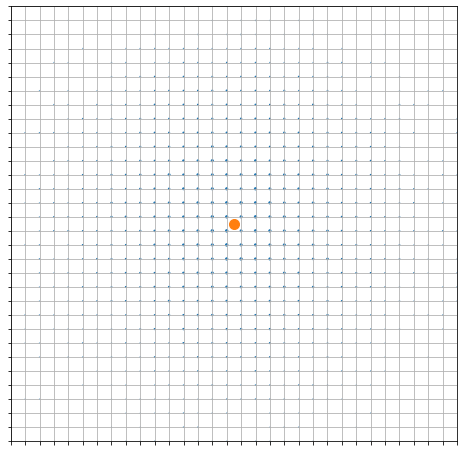

In [8]:
##################### LOT Features #####################
rotations = rot_images_vox_LOT.transpose(2,0,1)
N_total = rotations.shape[0]
rotations = rotations.reshape(N_total, -1)

#Define references. Options are "true (even number of references)", "sheared (even number of references)", "Gaussian (1 or 5)"
n_ref = 1
ref_type = "Gaussian"

grid_size = num_samplepoints
x = np.linspace(0,grid_size-1,grid_size)
y = np.linspace(0,grid_size-1,grid_size)
num_gridPoints = range(0,grid_size)
grid_points=[]
for i in range(0,grid_size):
    for j in range(0,grid_size):
        grid_points.append([x[i], y[j]])
grid_points = np.asarray(grid_points)

#Mean and covariance for a Gaussian reference distribution
if ref_type == "Gaussian":
    if n_ref == 1:
        mu = np.array([(grid_size-1)/2,(grid_size-1)/2])
        sigma = 5
        Skew = np.array([[1,0],[0,1]])
        cov = pow(sigma,2)*Skew#np.identity(2)
        GaussianSamples, GaussianReference = DiscreteGaussian(mu,cov,x,y,grid_size,10000)
    elif n_ref == 5:
        mu_center = np.array([(grid_size-1)/2, (grid_size-1)/2])
        cov_center = pow(3,2)*np.identity(2)
        mu_1 = mu_center + np.array([-(grid_size-1)/3, -(grid_size-1)/3])
        mu_2 = mu_center + np.array([-(grid_size-1)/3, (grid_size-1)/3])
        mu_3 = mu_center + np.array([(grid_size-1)/3, -(grid_size-1)/3])
        mu_4 = mu_center + np.array([(grid_size-1)/3, (grid_size-1)/3])
        cov = pow(2,2)*np.identity(2)
        GaussianSamples_center, GaussianReference_center = DiscreteGaussian(mu_center,cov_center,x,y,grid_size,10000)
        GaussianSamples_tmp, GaussianReference_sw = DiscreteGaussian(mu_1,cov,x,y,grid_size,10000)
        GaussianSamples_tmp, GaussianReference_nw = DiscreteGaussian(mu_2,cov,x,y,grid_size,10000)
        GaussianSamples_tmp, GaussianReference_se = DiscreteGaussian(mu_3,cov,x,y,grid_size,10000)
        GaussianSamples_tmp, GaussianReference_ne = DiscreteGaussian(mu_4,cov,x,y,grid_size,10000)        

if n_ref == 5 and ref_type == "Gaussian":
    fig, ax = plt.subplots(1,1)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference_center)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference_sw)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference_nw)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference_se)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference_ne)
    ax.set_xlim([0,grid_size-1])
    ax.set_ylim([0,grid_size-1])
    ax.set_xticks(num_gridPoints)
    ax.set_yticks(num_gridPoints)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.tick_params(labelbottom=False)    
    ax.tick_params(labelleft=False) 
    #ax.set(title="Five Gaussian references")
    #plt.savefig("Images/Gaussianref5.png",bbox_inches="tight",facecolor="w",dpi=500)
elif n_ref == 1 and ref_type == "Gaussian":
    fig, ax = plt.subplots(1,1)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference)
    ax.scatter(mu[0],mu[1], s = 100)
    #ax.set_title("Single Gaussian reference",fontweight="bold")
    ax.set_xlim([0,grid_size-1])
    ax.set_ylim([0,grid_size-1])
    ax.set_xticks(num_gridPoints)
    ax.set_yticks(num_gridPoints)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.tick_params(labelbottom=False)    
    ax.tick_params(labelleft=False) 
    #plt.savefig("Images/Gaussianref1.png",bbox_inches="tight",facecolor="w",dpi=500)

    
#Squared Euclidean Cost matrix between the grid points
Cost = ot.dist(grid_points, grid_points, metric = "sqeuclidean")

reference = np.empty((n_ref,grid_size**2))

#Select reference images for "true" and "sheared" types
if ref_type != "Gaussian":
    for i in range(0,int(n_ref/2)):
        tmp_indx = np.random.randint(N_total-25,N_total)
        if ref_type == "true":
            reference[i] = ReferencePoolClass1[tmp_indx].flatten()
        elif ref_type == "sheared":        
            reference[i] = Pixels[id1][tmp_indx]
        reference[i] = (1/np.sum(reference[i]))*reference[i]
        
        
    for i in range(0,int(n_ref/2)):
        tmp_indx = np.random.randint(N_total-25,N_total)
        if ref_type == "true":
            reference[int(n_ref/2)+i] = ReferencePoolClass2[tmp_indx].flatten()
        elif ref_type == "sheared":
            reference[int(n_ref/2)+i] = Pixels[id2][tmp_indx]
        reference[int(n_ref/2)+i] = (1/np.sum(reference[int(n_ref/2)+i]))*reference[int(n_ref/2)+i]

elif ref_type == "Gaussian":
    if n_ref == 1:
        reference[0] = GaussianReference
    elif n_ref == 5:
        reference[0] = GaussianReference_center
        reference[1] = GaussianReference_sw
        reference[2] = GaussianReference_nw
        reference[3] = GaussianReference_se
        reference[4] = GaussianReference_ne
    for i in range(0,n_ref):
        reference[i] = (1/np.sum(reference[i]))*reference[i]
        

        
##################### LOT Embedding #####################
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

EmbeddingClass1 = []
tic_LOT = time.perf_counter()
for i in range(0,N_total):
    template = rotations[i]
    template = (1/np.sum(template))*template
        
    Embedding, Support = FullDiscreteEmbed(template,reference[0],Cost,grid_size) 
#     print('embedding shape', Embedding.shape)
    
    for j in range(1,n_ref):
        tmp1, tmp2 = FullDiscreteEmbed(template,reference[j],Cost,grid_size)
        Embedding = np.concatenate((Embedding,tmp1),axis=0)
        Support = np.concatenate((Support,tmp2),axis=0)
        del tmp1, tmp2

    EmbeddingClass1.append(Embedding)
toc_LOT = time.perf_counter() - tic_LOT    

print('time LOT',toc_LOT )

LOT_RotFeatures = np.array(EmbeddingClass1).reshape(len(EmbeddingClass1),-1)


LOT_MDSRot = man.MDS(n_components=2,metric='euclidean',).fit_transform(LOT_RotFeatures)

 Error Wass Distance =  0.1426 % 
 Error LOT Distance =  4.4512 % 
 Error no-coll CM Distance =  1.5861 % 
 Error no-coll GC Distance =  2.2659 %


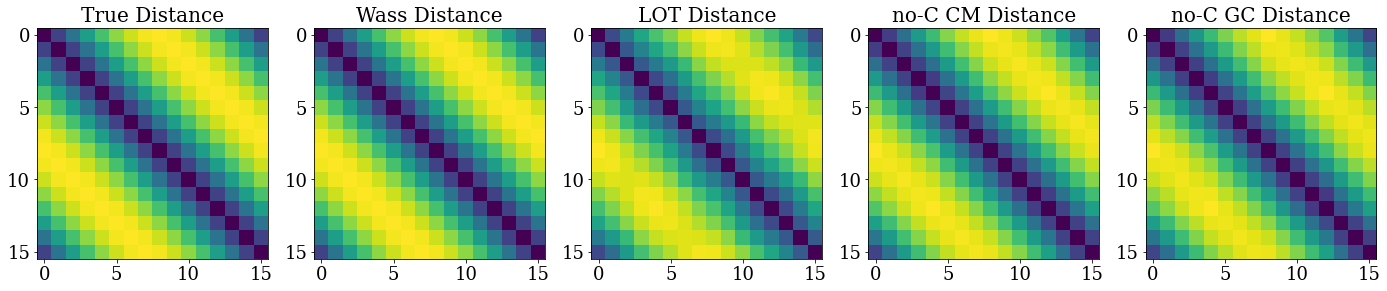

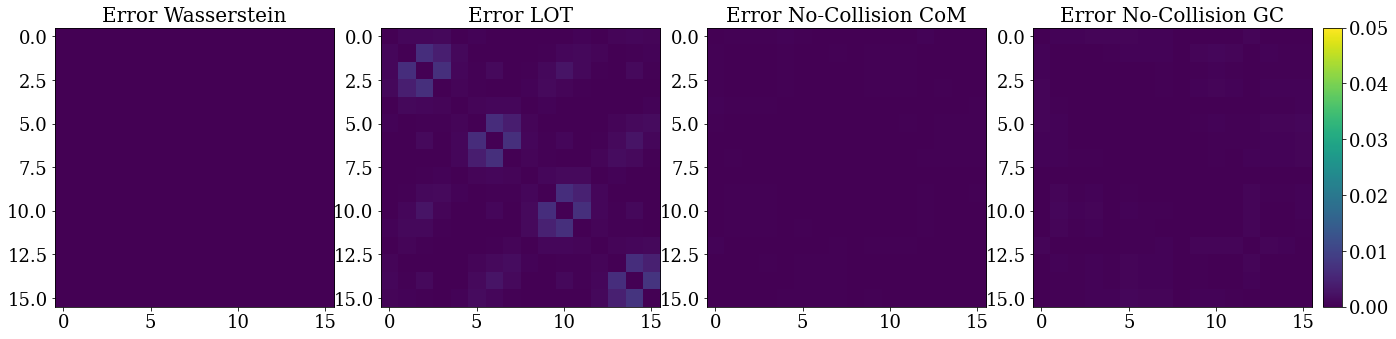

In [9]:
################# Distance Matrix Comparison #######################

def TrueWass_Ellipse(s,t,a,b,cx,cy):
    term1 = 4*(cx**2 + cy**2) * np.sin(0.5*(t-s))**2
    term2 = a**2 + b**2 - np.sqrt( (a**2 + b**2)**2*(np.cos(t-s))**2 + 4*a**2*b**2*(np.sin(t-s))**2 )
    W22 =  term1 + term2/2
    return W22

def TruedistMatrix(n_rotations, a,b):
    theta = np.linspace(0,2*np.pi,num=n_rotations,endpoint=False)
    distance = np.zeros((n_rotations,n_rotations))
    for s in range(n_rotations):
        for t in range(s+1,n_rotations):
            distance[s,t] = TrueWass_Ellipse(theta[s],theta[t],a,b,cx,cy)
    distance += distance.T
    return distance


LOTDist = NormalizeData(pairwiseDist(LOT_RotFeatures)**0.5)
noCMDist = NormalizeData(pairwiseDist(X_testCM)**0.5)
noGCDist = NormalizeData(pairwiseDist(X_testGC)**0.5)
Truedist = NormalizeData(TruedistMatrix(num_rotations, a,b)**0.5)
Wass_distance_norm = NormalizeData(Wass_distance**0.5)

relErr(Truedist, Wass_distance_norm)

print(' Error Wass Distance = ',relErr(Truedist, Wass_distance_norm),'% \n',
'Error LOT Distance = ',relErr(Truedist, LOTDist),'% \n',
'Error no-coll CM Distance = ',relErr(Truedist, noCMDist), '% \n',
'Error no-coll GC Distance = ',relErr(Truedist, noGCDist), '%')

fig = plt.figure(figsize=(24,5))
plt.subplot(1,5,1)
plt.imshow(Truedist)
plt.title('True Distance')

plt.subplot(1,5,2)
plt.imshow(Wass_distance_norm)
plt.title('Wass Distance')

plt.subplot(1,5,3)
plt.imshow(LOTDist)
plt.title('LOT Distance')

plt.subplot(1,5,4)
plt.imshow(noCMDist)
plt.title('no-C CM Distance')

plt.subplot(1,5,5)
plt.imshow(noGCDist)
plt.title('no-C GC Distance')


fig = plt.figure(figsize=(19.5,5))
dists =[Wass_distance_norm,LOTDist,noCMDist,noGCDist]
titles =['Error Wasserstein','Error LOT','Error No-Collision CoM','Error No-Collision GC' ]
# titles
top_lim = 0.05
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.65,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 label_mode="all"
                 )

for i,ax in enumerate(grid):
    im =ax.imshow((dists[i]-Truedist)**2, vmin=0, vmax = top_lim)
    ax.set_title(titles[i])
    
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

plt.tight_layout() 

    

Number of rotation samples =  15
Time for Wass Embedding =  14.958298971992917
Time for no-collision Embedding, (N=10) =  0.059371701907366514
Time for LOT Embedding =  0.4514958279905841


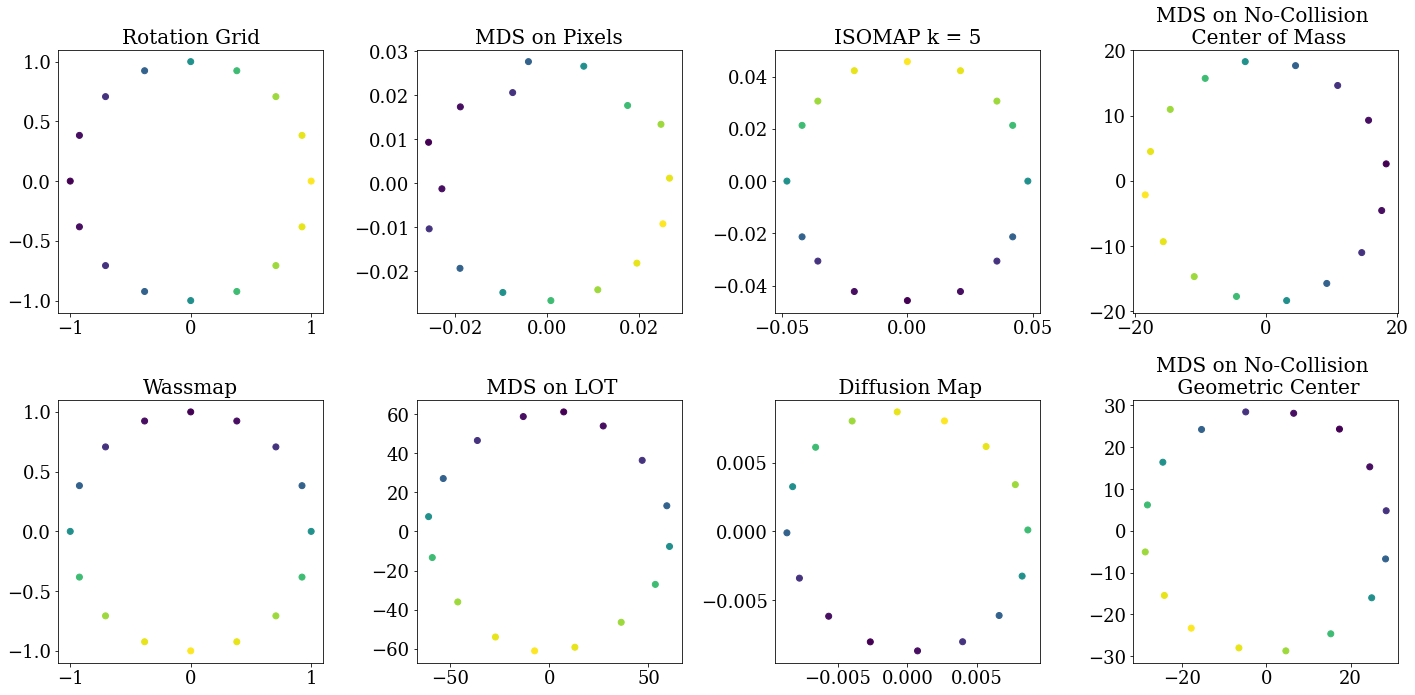

In [10]:
###################### Embedding Comparison #########################

print("Number of rotation samples = ", num_rotations-1)
print("Time for Wass Embedding = ", toc)
print("Time for no-collision Embedding, (N=10) = ",toc_NoC)
print("Time for LOT Embedding = ", toc_LOT)



plt.figure(figsize = (20,10))
plt.subplot(241)
plt.scatter(rotates[:,0],rotates[:,1], c = rotates[:,0])
plt.title("Rotation Grid")

plt.subplot(242)
scatter_x = rot_embedded_MDS[:,0]
scatter_y = rot_embedded_MDS[:,1]
plt.scatter(scatter_x, scatter_y, c = rotates[:,0])
plt.title("MDS on Pixels")

plt.subplot(243)
scatter_x = rot_embedded_isomap[:,0]
scatter_y = rot_embedded_isomap[:,1]
plt.scatter(scatter_x, scatter_y, c = rotates[:,0])
plt.title("ISOMAP k = 5")

plt.subplot(245)
scatter_x = WassEmbedding[:,0]
scatter_y = WassEmbedding[:,1]
plt.scatter(scatter_x,scatter_y, c = rotates[:,0])
plt.title("Wassmap")

plt.subplot(244)
scatter_x = mnist_embedded_MDS_NOcCM[:,0]
scatter_y = mnist_embedded_MDS_NOcCM[:,1]
plt.scatter(scatter_x, scatter_y, c = rotates[:,0])
plt.title("MDS on No-Collision \n Center of Mass")

plt.subplot(248)
scatter_x = mnist_embedded_MDS_NOcGC[:,0]
scatter_y = mnist_embedded_MDS_NOcGC[:,1]
plt.scatter(scatter_x, scatter_y, c = rotates[:,0])
plt.title("MDS on No-Collision \n Geometric Center")

plt.subplot(247)
scatter_x = rot_embedded_DiffMap[:,0]
scatter_y = rot_embedded_DiffMap[:,1]
plt.scatter(scatter_x, scatter_y, c = rotates[:,0])
plt.title(" Diffusion Map")

plt.subplot(246)
scatter_x = LOT_MDSRot[:,0]
scatter_y = LOT_MDSRot[:,1]
plt.scatter(scatter_x, scatter_y, c = rotates[:,0])
plt.title(" MDS on LOT")


plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Time (s) v.s. Rotation Points')

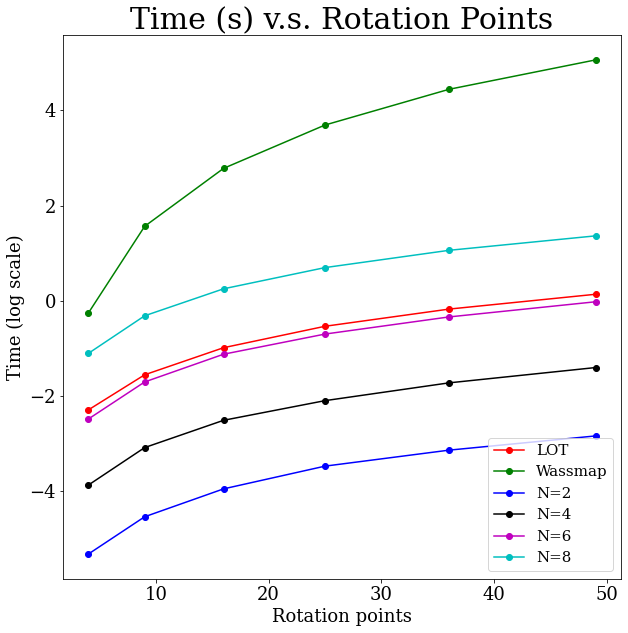

In [12]:
################# Computational Time Comparison #########################

num_samplepoints = 32
ellipse = generate_ellipse([3,2], 1, .5, samples = num_samplepoints)

# Generate translation set
rotation_pts = [i**2 for i in range(2,8)]
timeLOT = []
timeWass = []
timeN2 = []
timeN4 = []
timeN6 = []
timeN8 = []

for num_rotations in rotation_pts:
    theta = np.linspace(0,2*np.pi,num=num_rotations)
    x = np.cos(theta)
    y = np.sin(theta)
    rotates = np.zeros((num_rotations,2))
    for i in range(len(x)):
        rotates[i,0] = x[i]
        rotates[i,1] = y[i]

    # Generate translation images and image tensor
    rot_images = np.zeros((ellipse.shape[0],ellipse.shape[1],num_rotations))
    for i in range(num_rotations):
        rot_images[:,:,i] = rotation(ellipse,theta[i])

    rot_images = []
    for i in range(rotates.shape[0]):
        img = np.concatenate((rotation(ellipse,theta[i]),np.ones((ellipse.shape[0],1))/ellipse.shape[0]),axis=1)
        rot_images.append(img)

    # Generate voxel images (for ISOMAP)
    nvox = 32
    nxg = nvox
    nyg = nvox

    xg = np.linspace(-7,7,nxg)
    yg = np.linspace(-7,7,nyg)
    xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
    grid = np.stack((xxg,yyg))
    rot_images_vox = np.zeros((nvox,nvox,len(rot_images)))
    for i in range(len(rot_images)):
        pc = rot_images[i]
        rot_images_vox[:,:,i] = pointcloud_to_vox(pc,grid)
        
    ##########################################LOT##############################################################
    #the reference is independent of the data so we define it only once above
    rotations = rot_images_vox.transpose(2,0,1)
    N_total = rotations.shape[0]
    rotations = rotations.reshape(N_total, -1)
        
    #EmbeddingLOT
    #Import required packages
    def warn(*args, **kwargs):
        pass
    import warnings
    warnings.warn = warn

    EmbeddingClass1 = []
    tic_LOT = time.perf_counter()
    for i in range(0,N_total):
        template = rotations[i]
        template = (1/np.sum(template))*template

        Embedding, Support = FullDiscreteEmbed(template,reference[0],Cost,grid_size) 
    #     print('embedding shape', Embedding.shape)

        for j in range(1,n_ref):
            tmp1, tmp2 = FullDiscreteEmbed(template,reference[j],Cost,grid_size)
            Embedding = np.concatenate((Embedding,tmp1),axis=0)
            Support = np.concatenate((Support,tmp2),axis=0)
            del tmp1, tmp2

        EmbeddingClass1.append(Embedding)
        
    toc_LOT = time.perf_counter() - tic_LOT    
    timeLOT.append(toc_LOT)
    
    
    
    
    
     ## Circle translation test :: Compute Wasserstein square distance matrix
    tic = time.perf_counter()
    Wass_distance_trans = Wasserstein_Matrix(rot_images,squared=False)
    toc = time.perf_counter() - tic
    timeWass.append(toc)
    
    NN = 2
    imgVox_NoC = rot_images_vox.T
    tic_NoC = time.perf_counter()
    X_testCM, X_testGC = features_mat(imgVox_NoC,NN)
    toc_NoC = time.perf_counter() - tic_NoC
    timeN2.append(toc_NoC)
    
    NN = 4
    imgVox_NoC = rot_images_vox.T
    tic_NoC = time.perf_counter()
    X_testCM, X_testGC = features_mat(imgVox_NoC,NN)
    toc_NoC = time.perf_counter() - tic_NoC
    timeN4.append(toc_NoC)
    
    NN = 6
    imgVox_NoC = rot_images_vox.T
    tic_NoC = time.perf_counter()
    X_testCM, X_testGC = features_mat(imgVox_NoC,NN)
    toc_NoC = time.perf_counter() - tic_NoC
    timeN6.append(toc_NoC)
    
    NN = 8
    imgVox_NoC = rot_images_vox.T
    tic_NoC = time.perf_counter()
    X_testCM, X_testGC = features_mat(imgVox_NoC,NN)
    toc_NoC = time.perf_counter() - tic_NoC
    timeN8.append(toc_NoC)
        
rotation_pts = [i**2 for i in range(2,8)]

plt.figure(figsize = (10,10))

plt.plot(rotation_pts, np.log(timeLOT),'-o',label ='LOT', c = 'r')
plt.plot(rotation_pts, np.log(timeWass),'-o',label ='Wassmap', c = 'g')
plt.plot(rotation_pts, np.log(timeN2),'-o', label ='N=2', c = 'b')
plt.plot(rotation_pts, np.log(timeN4),'-o', label ='N=4',c = 'k')
plt.plot(rotation_pts, np.log(timeN6),'-o', label ='N=6', c = 'm')
plt.plot(rotation_pts, np.log(timeN8),'-o', label ='N=8',c = 'c')
plt.legend(prop={'size': 15}, loc = 'lower right')
plt.xlabel('Rotation points',fontsize = 18)
plt.ylabel('Time (log scale)',fontsize = 18)
plt.title('Time (s) v.s. Rotation Points', fontsize = 30)   
    